In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(len(counts))
print(len(weather))
print(counts[:5])
print(weather[:5])

61296
1340
                     Fremont Bridge East Sidewalk  \
Date                                                
2019-01-01 00:00:00                           0.0   
2019-01-01 01:00:00                           2.0   
2019-01-01 02:00:00                           1.0   
2019-01-01 03:00:00                           1.0   
2019-01-01 04:00:00                           2.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2019-01-01 00:00:00                           9.0  
2019-01-01 01:00:00                          22.0  
2019-01-01 02:00:00                          11.0  
2019-01-01 03:00:00                           2.0  
2019-01-01 04:00:00                           1.0  
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW0

In [4]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily[:5])

             Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0
2012-10-05  3148.0
2012-10-06  2006.0
2012-10-07  2142.0


In [5]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun
Date                                                 
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0


In [6]:
# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                          
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0


             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs  \
Date                                                                           
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359   
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142   
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038   
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056   
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208   

            PRCP  Temp (C)  dry day    annual  
Date                                           
2012-10-03   0.0     13.35      1.0  0.000000  
2012-10-04   0.0     13.60      1.0  0.002740  
2012-10-05   0.0     15.30      1.0  0.005479  
2012-10-06   0.0     15.85      1.0  0.008219  
2012-10-07   0.0     15.85      1.0  0.010959  


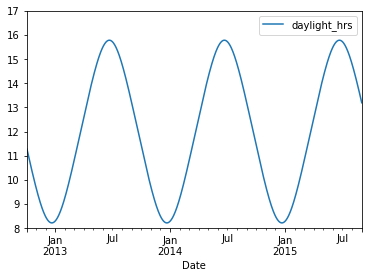

In [11]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

print(daily[:5])

In [12]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

#daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')
print(daily)

daily[:5]

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs  \
Date                                                                           
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359   
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142   
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038   
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056   
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208   
...            ...  ...  ...  ...  ...  ...  ...  ...      ...           ...   
2015-08-28  2653.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     13.418591   
2015-08-29   699.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     13.362212   
2015-08-30  1213.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     13.305611   
2015-08-31  2823.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0     13.248802   
2015-09-01  2876.0  0.0  1.0  0.0  0.0  

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP_left,Temp (C)_left,dry day_left,annual,PRCP_right,Temp (C)_right,dry day_right
Date,,,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000,0.0,1.335,1
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740,0.0,1.360,1
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479,0.0,1.530,1
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219,0.0,1.585,1
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959,0.0,1.585,1


In [13]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.
print(daily['annual'])

Date
2012-10-03    0.000000
2012-10-04    0.002740
2012-10-05    0.005479
2012-10-06    0.008219
2012-10-07    0.010959
                ...   
2015-08-28    2.901370
2015-08-29    2.904110
2015-08-30    2.906849
2015-08-31    2.909589
2015-09-01    2.912329
Freq: D, Name: annual, Length: 1064, dtype: float64


In [14]:
# Drop any rows with null values

daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP_right', 'dry day_right', 'Temp (C)_right', 'annual']
x1 = daily[column_names]
x = daily['daylight_hrs']
y = daily['Total']
print(x1)
print('***************')
print(y)

            Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs  \
Date                                                                   
2012-10-03  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359   
2012-10-04  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142   
2012-10-05  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038   
2012-10-06  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056   
2012-10-07  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208   
...         ...  ...  ...  ...  ...  ...  ...      ...           ...   
2015-08-28  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     13.418591   
2015-08-29  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     13.362212   
2015-08-30  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     13.305611   
2015-08-31  1.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0     13.248802   
2015-09-01  0.0  1.0  0.0  0.0  0.0  0.0  0.0      0.0     13.191795   

            PRCP_right  dry day_right  Temp (C)_right    annual

[0.76236871 0.74794215 0.77221239 0.84538276 0.7355564  0.76066698
 0.82227323 0.74830747 0.7751928  0.72185004]
0.7691752923789923


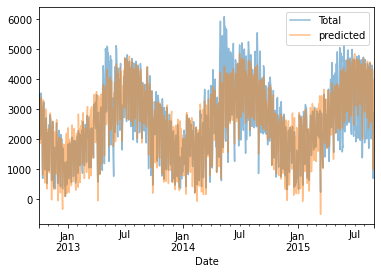

In [15]:
model = LinearRegression(fit_intercept=False)
model.fit(x1, y)
daily['predicted'] = model.predict(x1)

daily[['Total', 'predicted']].plot(alpha=0.5);

from sklearn.model_selection import cross_val_score
cur_score = cross_val_score(model, x1, y, cv=10)
print(cur_score)
print(cur_score.mean())

In [16]:
model2 = Lasso(fit_intercept=False)
parameters = {'alpha': sp_rand()}
randomSearch1 = RandomizedSearchCV(estimator=model2, param_distributions=parameters, n_iter=100,cv=10)
randomSearch1.fit(x1, y)
lasso_cur_score = cross_val_score(model2, x1, y, cv=10)
print("Lasso cross validation scores:")
print(lasso_cur_score)
print("Alpha Results from RandomSearchCV " )
print(randomSearch1.best_estimator_.alpha)

Lasso cross validation scores:
[0.71063985 0.73735637 0.76143884 0.80376921 0.70845719 0.75837987
 0.80245367 0.69930381 0.76733938 0.71127315]
Alpha Results from RandomSearchCV 
0.0008437515953970687


In [19]:
model3 = Ridge(fit_intercept=False)
parameters = {'alpha': sp_rand()}
randomSearch2= RandomizedSearchCV(estimator=model3,param_distributions=parameters, n_iter=100,cv=10)
randomSearch2.fit(x1, y)
ridge_cur_score = cross_val_score(model3, x1, y, cv=10)
print("Ridge cross validation scores:")
print(ridge_cur_score)
print("Alpha Results from RandomSearchCV " )
print(randomSearch2.best_estimator_.alpha)

Ridge cross validation scores:
[0.7064912  0.73814414 0.76369085 0.80533217 0.70574386 0.75336846
 0.80565438 0.70223634 0.76642817 0.72006282]
Alpha Results from RandomSearchCV 
0.015903806814167143
